## Pizza Classifier

### Necessary imports

In [41]:
import tensorflow as tf 
import os 
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers
from keras.regularizers import l2

The model underwent training on Apple M series processors with an arm architecture. Notably, it has been observed that Apple's Metal GPU yields distinct results compared to models trained on Linux or Windows platforms. To mitigate potential inconsistencies, we take the precautionary measure of disabling the GPU during training. This ensures that Tensorflow exclusively utilizes CPU code, fostering consistency across different architectures.

Change this setting accordingly depending on your training environment.

In [42]:
tf.config.experimental.set_visible_devices([], 'GPU')

In [43]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

if not os.path.exists(f"{current_working_directory}/Datasets"):
    os.makedirs(f"{current_working_directory}/Datasets")

print(f"[DATASET] PUT THE DATASET here: {current_working_directory}/Datasets")


[DATASET] PUT THE DATASET here: /Users/farouq/Documents/School/2nd Sem/CV & Sensor Fusion/assignments/Datasets


In [44]:
# get the directory where I want to download the dataset
path_of_dataset = os.path.join(*['..', current_working_directory, 'Datasets', 'pizza_not_pizza'])
print(f"[DIR] The directory of the current dataset is {path_of_dataset}")

[DIR] The directory of the current dataset is /Users/farouq/Documents/School/2nd Sem/CV & Sensor Fusion/assignments/Datasets/pizza_not_pizza


### Data preparation

In [45]:
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    """
    This function help you to load the data dynamically 
    :param data_set_path: (str) put the path created in the previous cell (is the dataset path) 
    :param target_size: (tuple) the desired size of the images  
    :return: 
        - array of images 
        - array with labels 
        - list of labels name (this is used for better visualization)
    """
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(*[data_set_path, class_name])
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to name _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

#### Load the data 

The target size of 224 x 224 x 3 is specified according to the instructions. The images are coloured (RGB) and hence have 3 channels

In [46]:
TARGET_SIZE = (224, 224, 3)

In [47]:
# load the data 
data, labels, label_names = load_the_data_and_the_labels('../Datasets/pizza_not_pizza/', target_size=TARGET_SIZE)

[WALK] I am walking into ../Datasets/pizza_not_pizza/not_pizza
[WALK] I am walking into ../Datasets/pizza_not_pizza/pizza


#### Normalize the data 

The data has been normalized by scaling the RGB values using the highest possible value, which is 255. Consequently, all pixel values in the images now fall within the range of 0 to 1, making the data suitable for neural network training where input values are typically expected to be within this standardized range.

In [48]:
# normalize the data 
data = data / 255.0

#### Split the data use the train_test_split function 

In [49]:
# split the data in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [ ]:
X_train

To ensure a representative validation set during training, we employ a shuffling mechanism for the training set. Utilizing the `validation_split` parameter within the `model.fit()` function, we designate 10% of the training data for validation during the training process. This approach enhances the model's ability to generalize effectively by assessing its performance on a diverse and representative validation subset.

In [50]:
random_indices = np.random.permutation(len(X_train))
X_train = X_train[random_indices]
y_train = y_train[random_indices]

### Create the CNN according to the following instructions:

        a. An Input layer.
        b. Data augmentation, with random flip (horizontal and vertical) and random rotation (0.2).
        c. Two hidden layers each composed with the following characteristics: 16 conv2d units, max pooling 2d and batch normalization, the second one should have 24 conv2d units max pooling 2d and batch normalization. 
        d. After this, add a flatten layer and a dense layer with 8 units
        e. Add the final classifier (a  dense layer) with the correct number of output and activation
        

In [51]:
model = keras.Sequential()

model.add(layers.Input(shape=TARGET_SIZE))

model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 112, 112, 16)      64        
 chNormalization)                                                
                                                      

### Compile the model 
Compile the model with Adam optimizer and binary cross entropy as loss function. 

In [52]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

### Train the model with 128 epochs and 64 batch size 

In [53]:
history = model.fit(X_train, y_train, epochs=128, batch_size=64, validation_split=0.1)

Epoch 1/128
20/20 [==============================] - 9s 418ms/step - loss: 1.4556 - accuracy: 0.6179 - val_loss: 0.9525 - val_accuracy: 0.5290
Epoch 2/128
20/20 [==============================] - 7s 375ms/step - loss: 0.9164 - accuracy: 0.6696 - val_loss: 1.1903 - val_accuracy: 0.4420
Epoch 3/128
20/20 [==============================] - 8s 382ms/step - loss: 0.8900 - accuracy: 0.7100 - val_loss: 1.7057 - val_accuracy: 0.4565
Epoch 4/128
20/20 [==============================] - 8s 377ms/step - loss: 0.8488 - accuracy: 0.7278 - val_loss: 2.2986 - val_accuracy: 0.4565
Epoch 5/128
20/20 [==============================] - 8s 378ms/step - loss: 0.8036 - accuracy: 0.7399 - val_loss: 2.9090 - val_accuracy: 0.4565
Epoch 6/128
20/20 [==============================] - 8s 379ms/step - loss: 0.7801 - accuracy: 0.7391 - val_loss: 3.5212 - val_accuracy: 0.4638
Epoch 7/128
20/20 [==============================] - 8s 374ms/step - loss: 0.7510 - accuracy: 0.7439 - val_loss: 3.8038 - val_accuracy: 0.4638

### Evaluate the model and report the accuracy 

In [54]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Accuracy: {test_accuracy * 100:.2f}%')

19/19 [==============================] - 1s 47ms/step - loss: 0.5578 - accuracy: 0.7898
Accuracy: 78.98%


The model with the initial architecture achieved a training accuracy of 87% and test accuracy of ~79%. The plots of the accuracy, confusion matrix and ROC curves is shown below:

### Plotting the accuracy graph

This function accepts a history object and generates two insightful graphs:
1. A visualization depicting the evolution of both training and validation loss during the model's training process.
2. A graphical representation showcasing the training and validation accuracy of the model across epochs.

In [55]:
def plot_accuracy_graph(history): 
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ["loss","val_loss"]].plot()
    history_frame.loc[:, ["accuracy","val_accuracy"]].plot()

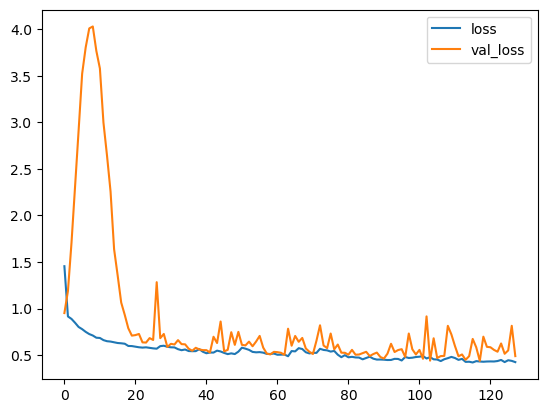

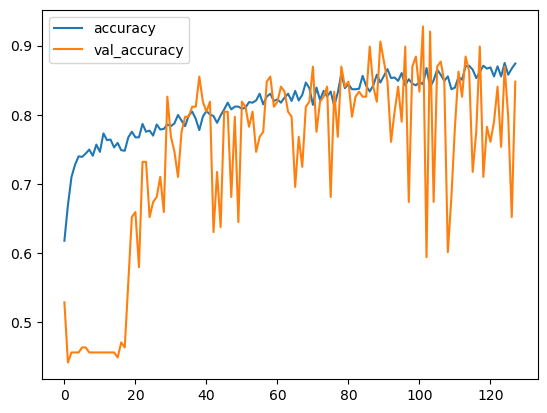

In [56]:
plot_accuracy_graph(history)

### Make prediction with the test set

Ensure to use appropriate prediction boundary for sigmoid activations

In [57]:
def make_predictions(model, test_set):
    predictions = model.predict(test_set)

    binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

    return binary_predictions

In [58]:
predictions = make_predictions(model, X_test)

19/19 [==============================] - 1s 43ms/step


### Show predictions

In [59]:
def show_some_prediction(number_of_subplot, test_set, predictions, name_of_the_labels):
    for i in range(number_of_subplot):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_set[i])
        plt.title(f'{name_of_the_labels[predictions[i]]}')
        plt.axis("off")
    plt.show()

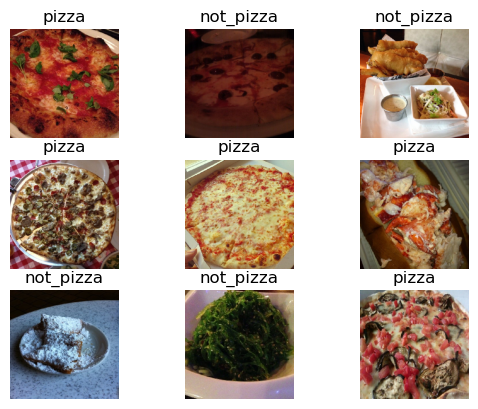

In [60]:
show_some_prediction(9, X_test, predictions, label_names)

### Model metrics
1. **Confusion Matrix:**
   - A table summarizing a classification model's predictions, providing counts of true positives, true negatives, false positives, and false negatives.

2. **ROC Curve (Receiver Operating Characteristic):**
   - A graphical representation showcasing a model's ability to distinguish between classes by plotting true positive rate against false positive rate at different thresholds.

3. **Precision-Recall Curve:**
   - A graph illustrating the balance between precision and recall at various probability thresholds in binary classification models.

### Visualization Functions
In this segment, we introduce three functions with distinct visualizations:
1. `show_confusion_matrix()`: This function presents a graphical representation of the confusion matrix, derived from the earlier model predictions.
2. `show_roc_curve()`: A function that exhibits the Receiver Operating Characteristic (ROC) curve, showcasing the model's performance based on prior predictions.
3. `show_precision_recall_curve()`: This function visualizes the Precision-Recall curve, offering insights into the model's precision and recall dynamics following its predictions.

In [61]:
# Confusion Matrix

def show_confusion_matrix(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="g",
        cmap="Blues",
        xticklabels=["Pizza", "Not_Pizza"],
        yticklabels=["Pizza", "Not_Pizza"],
    )
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [62]:
# ROC Curve
def show_roc_curve(true_labels, predictions):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [63]:
def show_precision_recall_curve(true_labels, predictions):
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

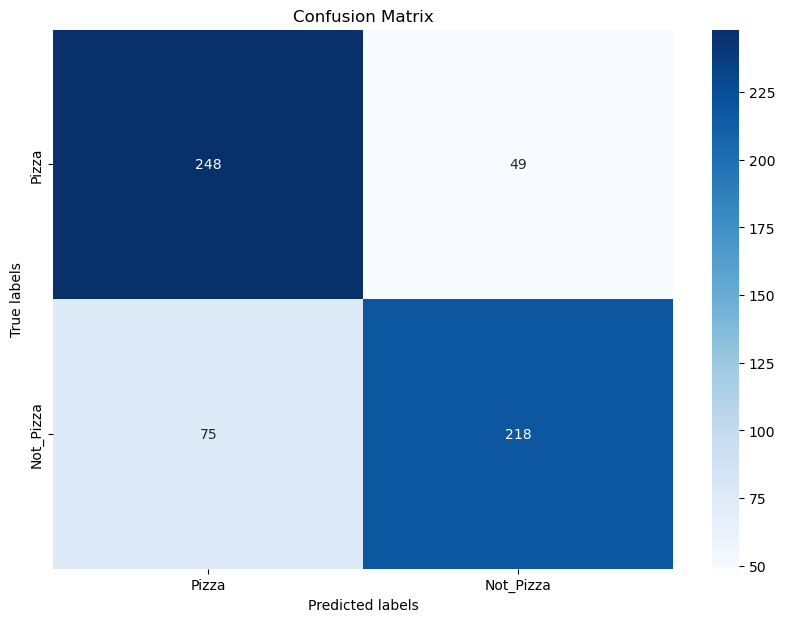

In [64]:
show_confusion_matrix(y_test, predictions)

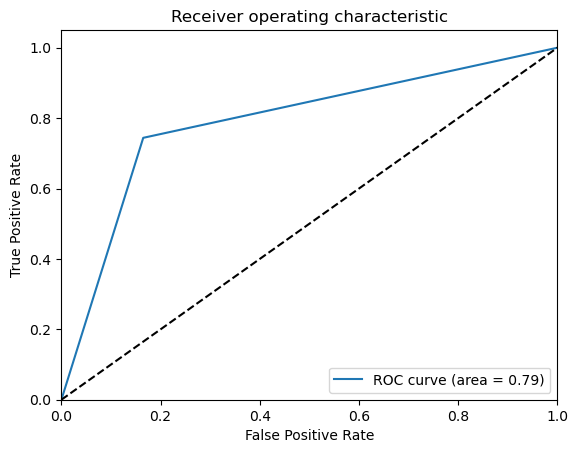

In [65]:
show_roc_curve(y_test, predictions)

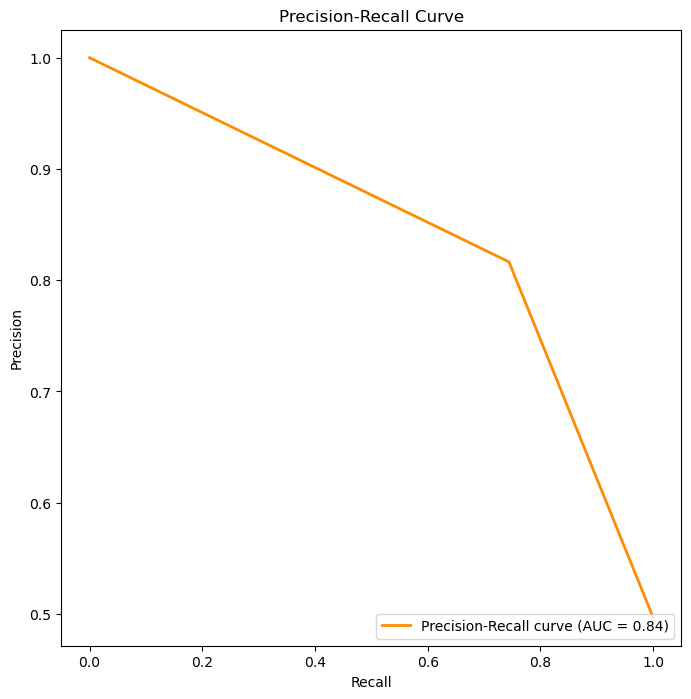

In [66]:
show_precision_recall_curve(y_test, predictions)

### Build another base CNN, but at add an extra hidden layer with 32 units of conv2d. Repeat all the other steps. What happened to the accuracy of the model? Why did it happen?  

### Enhanced CNN model

We define an enhanced CNN model by incorporating an additional convolution layer featuring 32 units, aligning with the directives from the assignment. The augmented model complexity aims to bolster feature extraction capabilities, enhancing its ability to discriminate between pizza and non-pizza images. This strategic augmentation is anticipated to contribute to an overall improvement in model accuracy.

In [67]:
enhanced_model = keras.Sequential()

enhanced_model.add(layers.Input(shape=TARGET_SIZE))

enhanced_model.add(layers.RandomFlip("horizontal_and_vertical"))
enhanced_model.add(layers.RandomRotation(0.2))

enhanced_model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
enhanced_model.add(layers.MaxPooling2D(2, 2))
enhanced_model.add(layers.BatchNormalization())

enhanced_model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
enhanced_model.add(layers.MaxPooling2D(2, 2))
enhanced_model.add(layers.BatchNormalization())

enhanced_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
enhanced_model.add(layers.MaxPooling2D(2, 2))
enhanced_model.add(layers.BatchNormalization())

enhanced_model.add(layers.Flatten())
enhanced_model.add(layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)))

enhanced_model.add(layers.Dense(1, activation='sigmoid'))

enhanced_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 112, 112, 16)      64        
 chNormalization)                                                
                                                      

In [68]:
enhanced_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [69]:
enhanced_history = enhanced_model.fit(X_train, y_train, epochs=128, batch_size=64, validation_split=0.1)

Epoch 1/128
20/20 [==============================] - 10s 462ms/step - loss: 0.9205 - accuracy: 0.6405 - val_loss: 0.8627 - val_accuracy: 0.5797
Epoch 2/128
20/20 [==============================] - 9s 443ms/step - loss: 0.8050 - accuracy: 0.6785 - val_loss: 0.9486 - val_accuracy: 0.4638
Epoch 3/128
20/20 [==============================] - 9s 439ms/step - loss: 0.6974 - accuracy: 0.7512 - val_loss: 0.9466 - val_accuracy: 0.4638
Epoch 4/128
20/20 [==============================] - 9s 439ms/step - loss: 0.6467 - accuracy: 0.7722 - val_loss: 0.8858 - val_accuracy: 0.4783
Epoch 5/128
20/20 [==============================] - 9s 433ms/step - loss: 0.6416 - accuracy: 0.7633 - val_loss: 0.8673 - val_accuracy: 0.5435
Epoch 6/128
20/20 [==============================] - 9s 433ms/step - loss: 0.6059 - accuracy: 0.7811 - val_loss: 0.8489 - val_accuracy: 0.5580
Epoch 7/128
20/20 [==============================] - 9s 435ms/step - loss: 0.5751 - accuracy: 0.7924 - val_loss: 1.1794 - val_accuracy: 0.536

In [70]:
test_loss, test_accuracy = enhanced_model.evaluate(X_test, y_test)

print(f'Accuracy: {test_accuracy * 100:.2f}%')

19/19 [==============================] - 1s 51ms/step - loss: 0.5747 - accuracy: 0.8356
Accuracy: 83.56%


The model with the initial architecture achieved a training accuracy of ~92% and test accuracy of ~84%. The plots of the accuracy, confusion matrix and ROC curves is shown below:

### Visualizations

We employ the visualization functions defined earlier to plot the accuracy, predictions, confusion matrix, ROC curve and Precison-Recall curve of the model

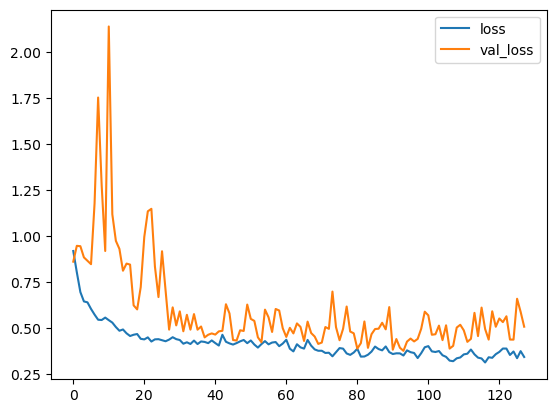

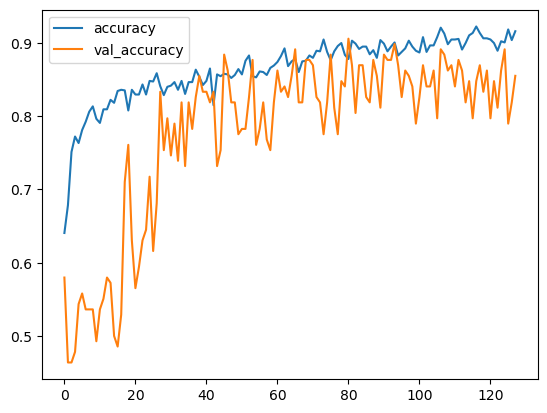

In [71]:
plot_accuracy_graph(enhanced_history)

In [72]:
preds = make_predictions(enhanced_model, X_test)

19/19 [==============================] - 1s 49ms/step


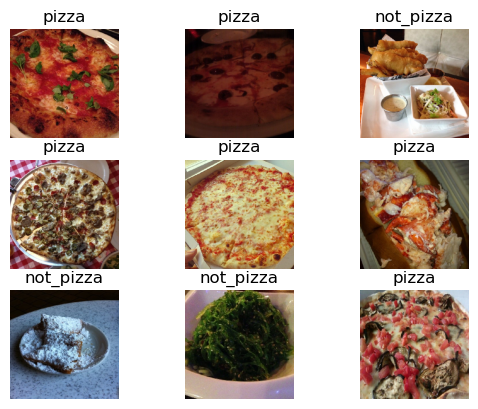

In [73]:
show_some_prediction(9, X_test, preds, label_names)

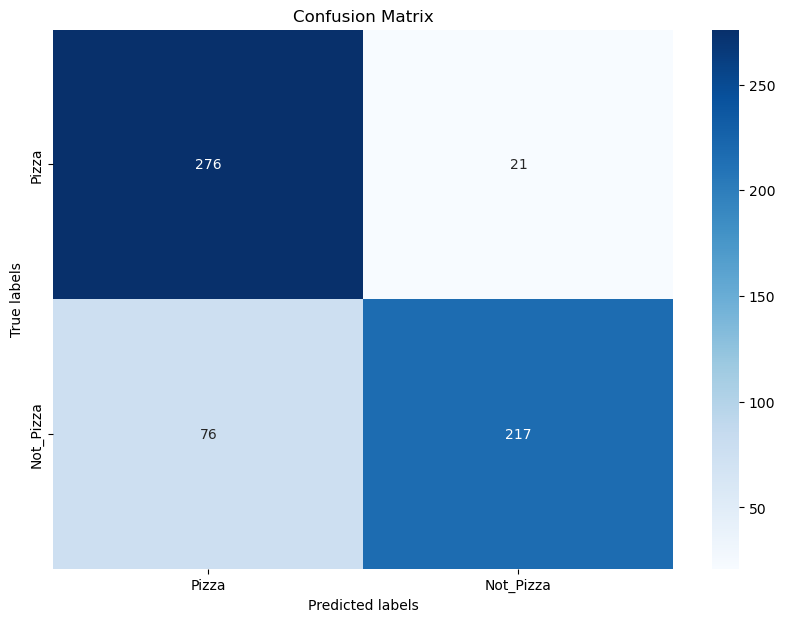

In [74]:
show_confusion_matrix(y_test, preds)

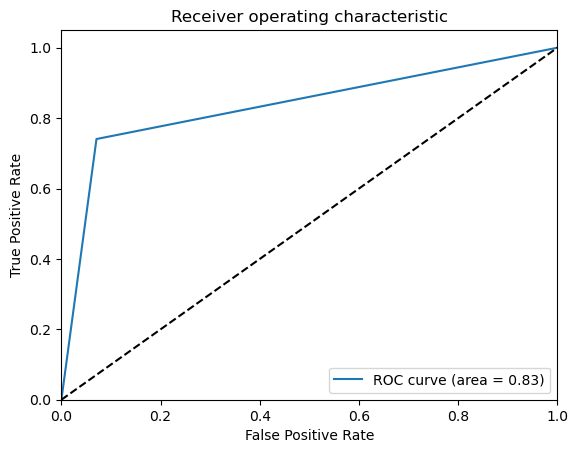

In [75]:
show_roc_curve(y_test, preds)

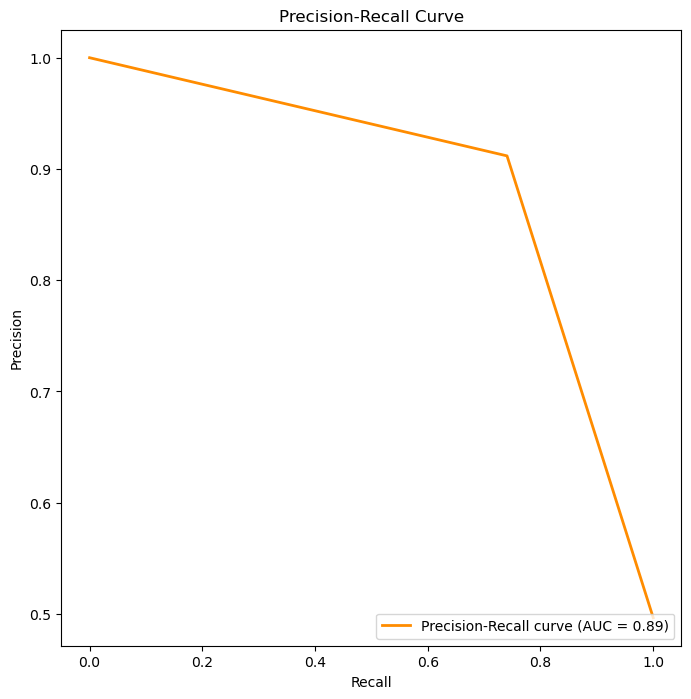

In [76]:
show_precision_recall_curve(y_test, preds)

After adding the Convolution layer with 32 units, with MaxPooling2D and BatchNormalization, the model's accuracy increased by approximately 5% in both training and test accuracies.

The increase in model accuracy after adding another `Conv2D` layer with 32 units can be attributed to the enhanced capacity for feature extraction and representation learning. The deeper architecture allows the model to capture more intricate patterns and hierarchical features in the input data, potentially improving its discriminative power.